In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
import transformers

In [4]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

# Importing dataset

In [5]:
import requests
url = "https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv"
r = requests.get(url, allow_redirects=True)
open('bbc-news.csv', 'wb').write(r.content)

5057493

In [6]:
df = pd.read_csv('bbc-news.csv')
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [7]:
df.shape

(2225, 2)

# Histogram of text frequency

In [8]:
df['count'] = df['text'].apply(lambda x :len(x.split()))

In [9]:
max(df['count'])

4492

In [10]:
df.head()

,category,text,count
0,tech,tv future in the hands of viewers with home th...,737
1,business,worldcom boss left books alone former worldc...,300
2,sport,tigers wary of farrell gamble leicester say ...,246
3,sport,yeading face newcastle in fa cup premiership s...,341
4,entertainment,ocean s twelve raids box office ocean s twelve...,260


<Figure size 800x800 with 0 Axes>

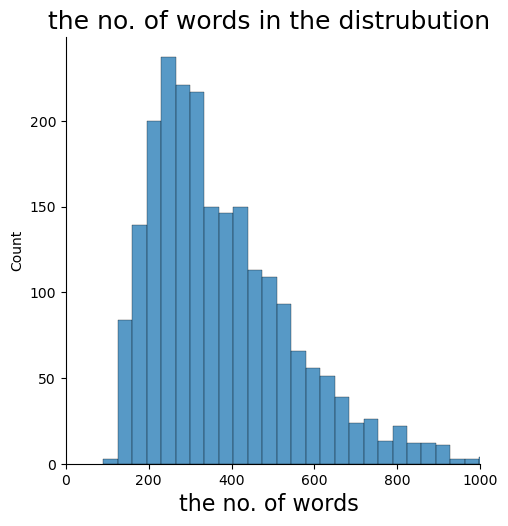

In [11]:
plt.figure(figsize=(8,8));
sns.displot(df['count']);
plt.xlim(0,1000)
plt.xlabel("the no. of words ",fontsize = 16)
plt.title("the no. of words in the distrubution ",fontsize = 18)
plt.show();

# Bar plot for each of the new category

In [12]:
category_count = df['category'].value_counts()
categories = category_count.index
categories

Index(['sport', 'business', 'politics', 'tech', 'entertainment'], dtype='object')

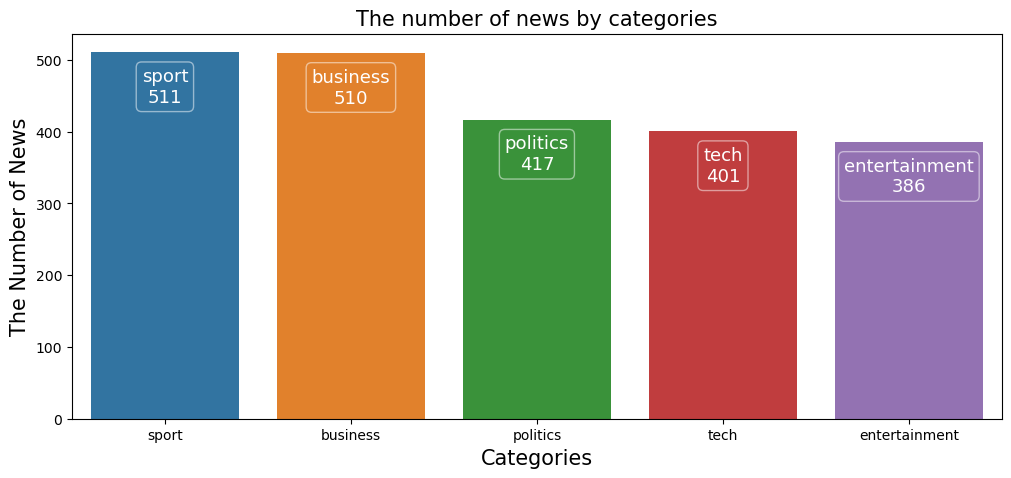

In [13]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
sns.barplot(x=category_count.index,y=category_count)

for a,p in enumerate(ax.patches):
    ax.annotate(f"{categories[a]}\n"+format(p.get_height(),'.0f'),xy=(p.get_x() + p.get_width() /2.0 , p.get_height()),xytext=(0,-25),size=13,color='white',ha='center',va='center',textcoords='offset points',bbox=dict(boxstyle='round',facecolor="none",edgecolor='white',alpha=0.5))
plt.xlabel('Categories',size=15)
plt.ylabel('The Number of News',size=15)
plt.title('The number of news by categories',size = 15)
plt.show()

In [14]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [15]:
# Encoding category
df["encoded_text"] = df["category"].astype('category').cat.codes
df.head()

,category,text,count,encoded_text
0,tech,tv future in the hands of viewers with home th...,737,4
1,business,worldcom boss left books alone former worldc...,300,0
2,sport,tigers wary of farrell gamble leicester say ...,246,3
3,sport,yeading face newcastle in fa cup premiership s...,341,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,1


In [16]:
table_lookup = pd.DataFrame(df.encoded_text.unique(),df.category.unique())
table_lookup = table_lookup.sort_values(by=[0])
table_lookup

,0
business,0
entertainment,1
politics,2
sport,3
tech,4


In [17]:
data_texts = df['text'].to_list()
data_labels = df['encoded_text'].to_list()

In [18]:
# Train Test split
train_texts,val_texts,train_labels,val_labels= train_test_split(data_texts,data_labels,test_size=0.2,random_state=0)
train_texts,test_texts,train_labels,test_labels = train_test_split(train_texts,train_labels,test_size=0.1,random_state=0)

In [19]:
len(train_texts)

1602

In [20]:
len(val_texts)

445

In [21]:
len(test_texts)

178

# Model Definition

In [22]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts,truncation=True,padding=True)
val_encodings = tokenizer(val_texts,truncation=True,padding=True)
test_encodings = tokenizer(test_texts,truncation=True,padding=True)

In [23]:
tokenizer.vocab_size,tokenizer.model_max_length,tokenizer.model_input_names
# 512 is the max an input text can be to the transformer tokenizer  

(30522, 512, ['input_ids', 'attention_mask'])

### Taking an example to show preprocessing 

In [24]:
example = "Sample Text"
example_encoded_text = tokenizer(example)
example_encoded_text

{'input_ids': [101, 7099, 3793, 102], 'attention_mask': [1, 1, 1, 1]}

In [25]:
example_tokens = tokenizer.convert_ids_to_tokens(example_encoded_text.input_ids)
tokenizer.convert_tokens_to_string(example_tokens)

'[CLS] sample text [SEP]'

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

test_set = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [27]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY")

os.environ['WANDB_MODE'] = 'online'
os.environ["WANDB_API_KEY"] = WANDB_API_KEY
wandb.init(project="huggingface")



wandb: Currently logged in as: mdarfan357. Use `wandb login --relogin` to force relogin


# Fine Tuning Transformer

In [28]:
from transformers import TFDistilBertForSequenceClassification,TFTrainer,TFTrainingArguments
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

# define performance metrics

def metrics(pred):
  label_prediction = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(label_prediction, preds, average="weighted")
  acc = accuracy_score(label_prediction, preds)
  return {"accuracy": acc, 
          "f1": f1
          }

training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=1e-5,
    logging_dir='./logs',
    eval_steps=100,
    disable_tqdm=False,
    evaluation_strategy = "epoch", #To calculate metrics per epoch
    logging_strategy="epoch", 
)
with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=5)
    
trainer = TFTrainer(
    model = trainer_model,
    args=training_args,
    compute_metrics=metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [29]:
trainer_model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,957,317
Trainable params: 66,957,317
Non-trainable params: 0
_________________________________________________________________


In [30]:
%%time
trainer.train()

CPU times: user 2min 2s, sys: 25.1 s, total: 2min 27s
Wall time: 6min 35s


In [31]:
trainer.evaluate()

{'eval_loss': 0.028161820024251938,
 'eval_accuracy': 0.9921875,
 'eval_f1': 0.9921768659255898}

In [32]:
pred = trainer.predict(val_dataset)
pred.metrics

{'eval_loss': 0.02655894123017788,
 'eval_accuracy': 0.9932584269662922,
 'eval_f1': 0.9932545131357936}

In [33]:
def plot_cm(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



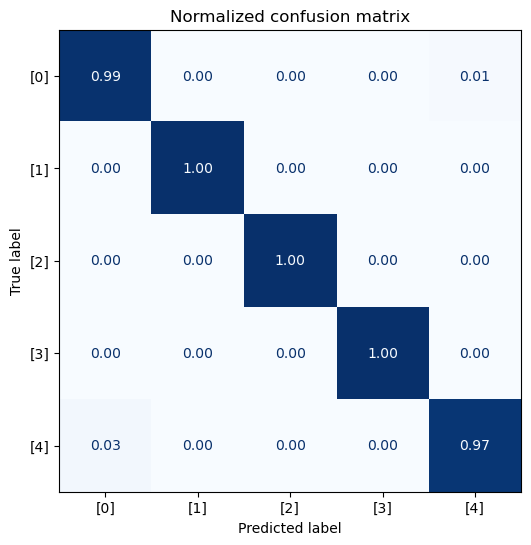

In [34]:
pred = trainer.predict(val_dataset)
y_pred = np.argmax(pred.predictions,axis=1)
plot_cm(y_pred,val_labels,table_lookup.values)

# Saving and Loading the model 

In [35]:
save_dir = "/saved_models"
trainer_model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
os.getcwd()

'/kaggle/working'

In [36]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_dir)
model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_dir)

Some layers from the model checkpoint at /saved_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /saved_models and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Testing Process using a single sample

In [37]:
test_text = test_texts[0]
test_text

'dollar hovers around record lows the us dollar hovered close to record lows against the euro on friday as concern grows about the size of the us budget deficit.  analysts predict that the dollar will remain weak in 2005 as investors worry about the state of the us economy. the bush administration s apparent unwillingness to intervene to support the dollar has caused further concern. however  trading has been volatile over the past week because of technical and automated trading and light demand. this has amplified reactions to news  analysts said  adding that they expect markets to become less jumpy in january.  the dollar was trading at $1.3652 versus the euro on friday morning after hitting a fresh record low of $1.3667 on thursday. one dollar bought 102.55 yen.  disappointing business figures from chicago triggered the us currency s weakness on thursday. the national association of purchasing management-chicago said its manufacturing index dropped to 61.2  a bigger fall than expect

In [38]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation=True,
    padding=True,
    return_tensors="tf"
)
output = model_fine_tuned(predict_input)[0]
prediction_value = tf.argmax(output,axis=1).numpy()[0]
prediction_value

0

In [39]:
table_lookup.iloc[prediction_value].name

'business'

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



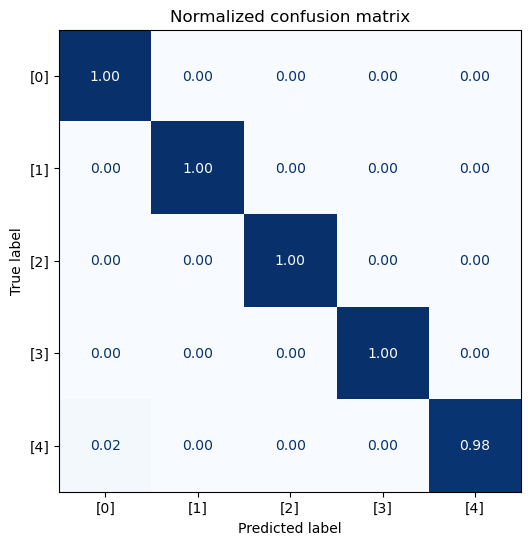

In [40]:
pred = trainer.predict(test_set)
y_pred = np.argmax(pred.predictions,axis=1)
plot_cm(y_pred,test_labels,table_lookup.values)

# Inferencing with Pytorch

In [41]:
import torch
from transformers import DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained(save_dir)
model = DistilBertForSequenceClassification.from_pretrained(save_dir,from_tf=True)

All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


In [42]:
predict_input = tokenizer.encode(
    test_text,
    truncation=True,
    padding=True,
    return_tensors="pt"
)
output = model(predict_input)
prediction_value = torch.argmax(output[0],dim=1).item()
prediction_value

0

In [43]:
table_lookup.iloc[prediction_value].name

'business'

# Testing on custom inputs

In [44]:
# sports
test_text = "RCB vs MI Highlights: Virat Kohli, Faf du Plessis help Royal Challengers Bangalore brush aside Mumbai Indians for first win"
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation=True,
    padding=True,
    return_tensors="tf"
)
output = model_fine_tuned(predict_input)[0]
prediction_value = tf.argmax(output,axis=1).numpy()[0]
table_lookup.iloc[prediction_value].name

'sport'

In [45]:
# entertainment
test_text = "Priyanka Chopra and Karan Johar hug each other at NMACC event after Priyanka whispers in husband Nick Jonas’ ear"
test_text = "A star is reborn: Zeenat Aman"
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation=True,
    padding=True,
    return_tensors="tf"
)
output = model_fine_tuned(predict_input)[0]
prediction_value = tf.argmax(output,axis=1).numpy()[0]
table_lookup.iloc[prediction_value].name

'entertainment'

In [46]:
# tech
test_text = "An AI researcher who has been warning about the technology for over 20 years says we should 'shut it all down,' and issue an 'indefinite and worldwide' ban"
test_text = "Astronomers discover flattest explosion ever seen in space"
test_text = 'Indian start-ups may take legal route against Google in-app billing'
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation=True,
    padding=True,
    return_tensors="tf"
)
output = model_fine_tuned(predict_input)[0]
prediction_value = tf.argmax(output,axis=1).numpy()[0]
table_lookup.iloc[prediction_value].name

'tech'

In [47]:
# politics
test_text = "BJP to organise protests across Rajasthan to corner Congress govt"
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation=True,
    padding=True,
    return_tensors="tf"
)
output = model_fine_tuned(predict_input)[0]
prediction_value = tf.argmax(output,axis=1).numpy()[0]
table_lookup.iloc[prediction_value].name

'politics'

In [48]:
test_text = "MPC may raise rate by another 25 bps as inflation woes persist: BS Poll"
test_text = 'RBI likely to hike benchmark interest rate by 25 bps on April 6'
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation=True,
    padding=True,
    return_tensors="tf"
)
output = model_fine_tuned(predict_input)[0]
prediction_value = tf.argmax(output,axis=1).numpy()[0]
table_lookup.iloc[prediction_value].name

'business'

In [49]:
!mkdir /kaggle/working/BERT/

# Saving the model

In [50]:
path = '/kaggle/working/BERT'
model_fine_tuned.save(path,save_format='tf')


